Parse Text Data, make Train Split
---

In [1]:
import glob
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, vstack
import numpy as np
from sklearn.preprocessing import normalize

def parse_lyrics():
    parsed = {"unique_line_ratios": [], "unique_word_ratios_song": [], "artists": [],
             "titles": [], "genres": [], "raw_lyrics": [], "total_word_counts": [], 
              "average_character_count_word":[]}
    
    #iterate through files
    for filename in glob.iglob('data/*.txt'):
        genre = filename[5:len(filename)-4]
        numberOfSongs = 0
        file = open(filename)
        lines = file.readlines()
        i = 0
        while i < len(lines) and not lines[i].startswith("###"):
            i = i + 1
        while i < len(lines):
            numberOfSongs = numberOfSongs + 1
            parsed["artists"].append(lines[i][3:].strip())
            parsed["titles"].append(lines[i+1][3:].strip())
            parsed["genres"].append(genre) 
            i = i + 2
            #extract features from song
            
            lyrics = []
            while i < len(lines) and not lines[i].startswith("###"):
                line = lines[i].strip()                
                if line != "":
                    lyrics.append(line)
                i = i + 1
                
            lyric_string = make_lyric_string(lyrics)
            
            parsed["raw_lyrics"].append(lyric_string)
            
            parsed["unique_line_ratios"].append(calc_unique_line_ratio(lyrics))
            parsed["unique_word_ratios_song"].append(calc_unique_word_ratio_song(lyric_string))
            
            parsed["total_word_counts"].append(count_words(lyric_string))
            parsed["average_character_count_word"].append(count_characters(lyric_string)/count_words(lyric_string))
               
    return parsed;

def calc_unique_line_ratio(lyrics):
    return len(set(lyrics)) / len(lyrics)

def make_lyric_string(lyric_lines):
    lyric_string = ''
    for l in lyric_lines:
        lyric_string += l+' '
    return lyric_string 

def count_words(lyric_string):
    return len(lyric_string.split())

def calc_unique_word_ratio_song(lyric_string):
    return len(set(lyric_string.split())) / len(lyric_string.split())

def count_characters(lyrics_string):
    return len(lyrics_string)-lyrics_string.count(' ')

##Parse The Data
parsed = parse_lyrics()
##Prepare "Dumb" Features
vectorizer = TfidfVectorizer()
data_bow = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

##Make More intelligent Features
data_feature = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

data_feature = np.append(data_feature, np.asarray(parsed["unique_line_ratios"]).reshape(-1, 1), 1)
##data_feature = np.append(data_feature, normalize(np.asarray(parsed["unique_word_ratios_song"]).reshape(-1, 1)), 1)

data_feature = np.append(data_feature, normalize(np.asarray(parsed["total_word_counts"]).reshape(-1, 1)), 1)
##data_feature = np.append(data_feature, normalize(np.asarray(parsed["average_character_count_word"]).reshape(-1, 1)), 1)

titles_train, titels_test, raw_lyrics_train, raw_lyrics_test, X_train_feature, X_test_feature, X_train_bow, X_test_bow, y_train, y_test = train_test_split(parsed['titles'], parsed['raw_lyrics'], data_feature, data_bow, parsed['genres'], test_size=0.33, random_state=42)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Classify
---

In [2]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

cls = OneVsRestClassifier(LinearSVC(random_state=0))

cls.fit(X_train_feature, y_train)
pred_feature = cls.predict(X_test_feature)

cls.fit(X_train_bow, y_train)
pred_bow = cls.predict(X_test_bow)

Evaluate
---

### BOW Classifier ###



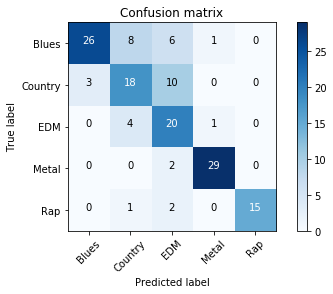

F1 micro: 0.739726027397
F1 macro: 0.756692339918


### Feature Classifier ###



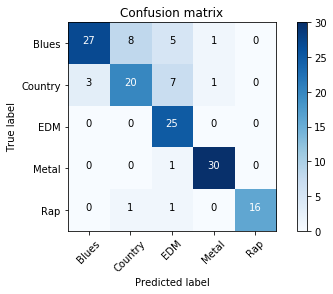

F1 micro: 0.808219178082
F1 macro: 0.820407493984


In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
print("### BOW Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_bow), ["Blues","Country", "EDM", "Metal", "Rap"])
print ("F1 micro: " + str(f1_score(pred_bow, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_bow, y_test, average='macro')))

print("\n\n### Feature Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_feature), ["Blues","Country", "EDM", "Metal", "Rap"])
print ("F1 micro: " + str(f1_score(pred_feature, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_feature, y_test, average='macro')))

Examine Mistakes in More Detail
---

In [4]:
for idx, genre in enumerate(y_test):
    if (genre != pred_feature[idx]):
        print ("\n###########################################################\n")
        print ("Song: "+titels_test[idx]+"\n")
        print ("Was "+genre+" Predicted "+pred_feature[idx])
        print ("\n"+raw_lyrics_test[idx])


###########################################################

Song: Cadillac Assembly Line

Was Blues Predicted Country

Goin' to Detroit, Michigan Girl, I can't take you Hey, I'm goin' to Detroit, Michigan Girl, you got to stay here behind Goin' to get me a job On the Cadillac assembly line I'm tired of whoopin' and hollerin' Up and down the Mississippi road Hey, I'm tired of whoopin' and hollerin' Pickin' that nasty cotton Gonna catch me a bus up North I won't have to keep sayin' yes, sir, boss Goin' to Detroit, Michigan Girl, I can't take you Hey, I'm goin' to Detroit, Michigan Girl, you got to stay here behind Goin' to get me a job On the Cadillac assembly line Well, girl, if you'll be alright And keep your blue jeans zipped up tight When I make my first check I'll put you on the Delta jet, hey hey I'm gonna send for you, darlin' Won't you come on home 

###########################################################

Song: I Made The Prison Band

Was Country Predicted EDM

Deep inside

Look At The Most Informative Words
---

In [5]:
def print_top10(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(vectorizer, cls,  ["Blues","Country", "EDM", "Metal", "Rap"])

Blues: woman down rain gonna yes blues man know well baby
Country: doodlin alone he that ve run heaven love heart and
EDM: re can yeah never light we oh go it be
Metal: another has from pain tune blood are the death of
Rap: doing this ain bitch up it get nigga shit snoop
